# Chest X-Ray Images (Pneumonia)

### Data 출처 (캐글) : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

데이터 세트는 3개의 폴더(train, test, val)로 구성되며 각 이미지 범주(Pneumonia/Normal)에 대한 하위 폴더를 포함합니다. 5,863개의 X-Ray 이미지(JPEG)와 2개의 class(폐렴/정상)가 있습니다.

흉부 X선 영상 분석을 위해 모든 흉부 방사선 사진은 품질 관리를 위해 처음에 품질이 낮거나 읽을 수 없는 스캔을 모두 제거하여 선별되었습니다. 그런 다음 AI 시스템 교육을 위해 승인되기 전에 두 명의 전문 의사가 이미지에 대한 진단을 평가했습니다. 등급 오류를 설명하기 위해 평가 세트도 전문가가 세 차례 확인했습니다.

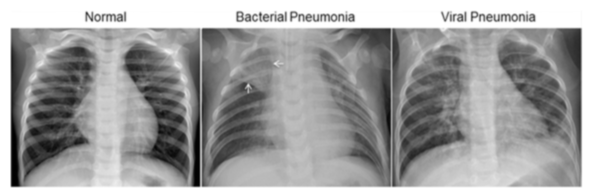

In [1]:
import os
import sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

## GPU 설정

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 데이터 확인

In [3]:
os.listdir("./chest_xray")

['train', '.DS_Store', 'chest_xray', 'val', '__MACOSX', 'test']

In [4]:
len(os.listdir("./chest_xray/train/PNEUMONIA")) # train 폐렴 이미지 개수 확인 

3875

In [5]:
len(os.listdir("./chest_xray/train/NORMAL")) # train 정상 이미지 개수 확인 

1341

## Class 불균형 해결 

class 간 불균형이 존재함으로 이를 해결하기 위해 아래와 같이 class_weight를 이용하였다.

In [6]:
train_dir = "./chest_xray/train"
test_dir = "./chest_xray/test"
val_dir = "./chest_xray/val"

num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


### 비정상 폐렴 환자 이미지 확인

In [7]:
sample_pneumonia_img = './chest_xray/train/PNEUMONIA/'+ os.listdir("./chest_xray/train/PNEUMONIA")[0]
sample_pneumonia_img

'./chest_xray/train/PNEUMONIA/person810_virus_1445.jpeg'

(1688, 2000)


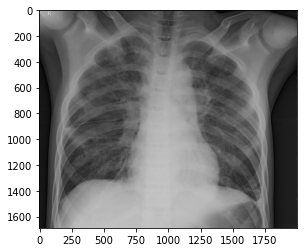

In [8]:
img = plt.imread(sample_pneumonia_img)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

### 정상 폐 이미지 확인

In [9]:
sample_normal_img = './chest_xray/train/NORMAL/'+ os.listdir("./chest_xray/train/NORMAL")[0]
sample_normal_img

'./chest_xray/train/NORMAL/NORMAL2-IM-1190-0001.jpeg'

(1576, 1746)


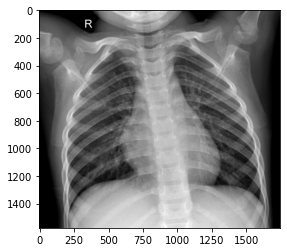

In [10]:
img = plt.imread(sample_normal_img)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

폐렴에 걸린 사람보다 정상인 사람의 폐 이미지가 확연이 깨끗함을 확인할 수 있다.

## train, validation, test 불러오기

#### flow_from_directory()
: 인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라고 간주하고 그 레이블이라고 <br>
간주한 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측하여 Numpy Array Iterator를 생성

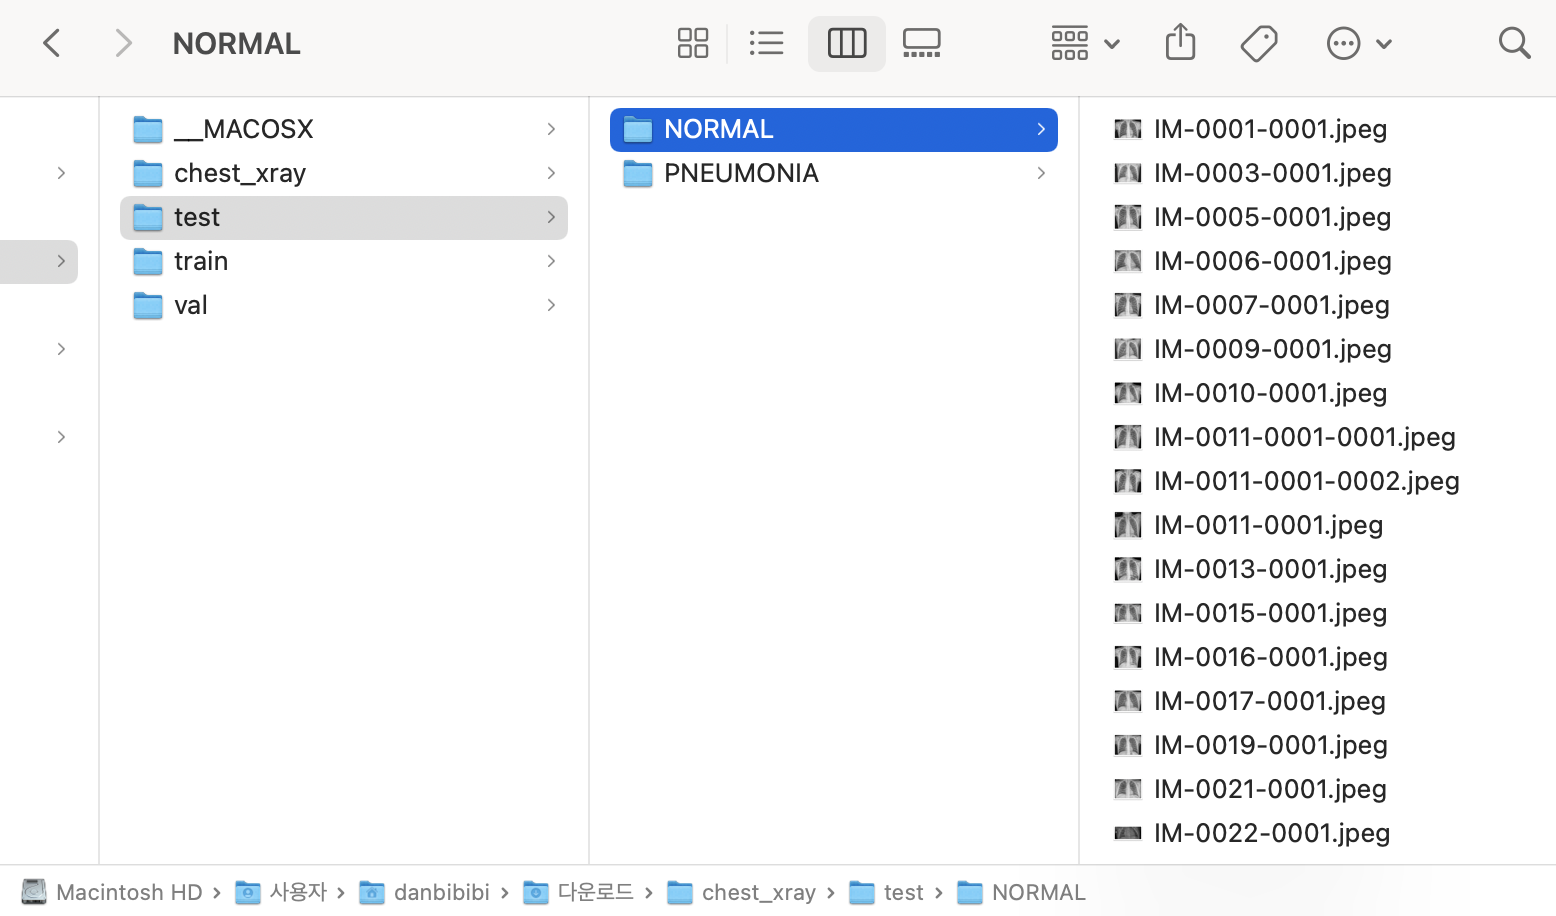

In [11]:
image_generator = ImageDataGenerator() # 폴더 형태로된 데이터 구조를 바로 가져와서 사용

train = image_generator.flow_from_directory(train_dir,
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='binary', # NORMAL, PNEUMONIA
                                            target_size=(180, 180)) # IMG RESIZE

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 모델링

In [12]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=(180,180,3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       7

## Train

In [13]:
model_path = './model/PneumoniaPredictionModel.hdf5'
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(train, validation_data=validation, epochs=10, class_weight=class_weight,
                   verbose=0, callbacks=[checkpointer, early_stopping_callback])


Epoch 00001: val_loss improved from inf to 0.35928, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00002: val_loss improved from 0.35928 to 0.28412, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00003: val_loss improved from 0.28412 to 0.27535, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00004: val_loss improved from 0.27535 to 0.12933, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00005: val_loss improved from 0.12933 to 0.03402, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00006: val_loss did not improve from 0.03402

Epoch 00007: val_loss did not improve from 0.03402

Epoch 00008: val_loss improved from 0.03402 to 0.03369, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00009: val_loss improved from 0.03369 to 0.00170, saving model to ./model/PneumoniaPredictionModel.hdf5

Epoch 00010: val_loss did not improve from 0.00170


## 시각화

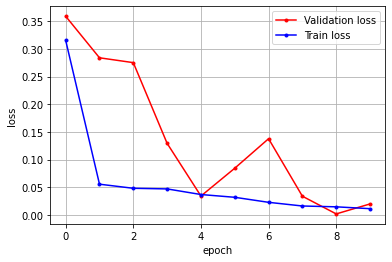

In [16]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Validation loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Train loss')
plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Test

In [17]:
evaluation = model.evaluate(test)
print("Test Accuracy: {:.2f}%".format(evaluation[1]*100))

624/624 [==============================] - 12s 19ms/step - loss: 2.2354 - accuracy: 0.7644
Test Accuracy: 76.44%
